In [4]:
import polars as pl

# Load datasets
DATA_PATH = "data"

# Core user data
profiles = pl.read_parquet(f"{DATA_PATH}/farcaster-profile_with_addresses-0-1733162400.parquet")
fids = pl.read_parquet(f"{DATA_PATH}/farcaster-fids-0-1733162400.parquet")
fnames = pl.read_parquet(f"{DATA_PATH}/farcaster-fnames-0-1733162400.parquet")

# Verification data
verifications = pl.read_parquet(f"{DATA_PATH}/farcaster-verifications-0-1733162400.parquet")
account_verifications = pl.read_parquet(f"{DATA_PATH}/farcaster-account_verifications-0-1733162400.parquet")

# Network data 
user_data = pl.read_parquet(f"{DATA_PATH}/farcaster-user_data-0-1733162400.parquet")

# Power users
power_users = pl.read_parquet(f"{DATA_PATH}/farcaster-warpcast_power_users-0-1733162400.parquet")
links = pl.read_parquet(f"{DATA_PATH}/farcaster-links-0-1733162400.parquet")

# Print basic stats
print("\nDataset Statistics:")
print(f"Total profiles: {len(profiles)}")
print(f"Total FIDs: {len(fids)}")
print(f"Total account verifications: {len(account_verifications)}")
print(f"Total power users: {len(power_users)}")

# Get latest fname for each FID
last_fnames = fnames[["fid","updated_at"]].group_by("fid").max()
last_fnames = last_fnames.join(
    fnames,
    on=["fid","updated_at"],
    how="left",
    coalesce=True
)[["fid","fname"]]

def extract_profile_features(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.col('fname').str.contains(r'\.eth$').cast(pl.Int32).alias('has_ens'),
        (pl.col('bio').is_not_null() & (pl.col('bio') != "")).cast(pl.Int32).alias('has_bio'),
        (pl.col('avatar_url').is_not_null()).cast(pl.Int32).alias('has_avatar'),
        pl.when(pl.col('verified_addresses').str.contains(','))
        .then(pl.col('verified_addresses').str.contains(',').cast(pl.Int32) + 1)
        .otherwise(pl.when(pl.col('verified_addresses') != '[]')
                  .then(1)
                  .otherwise(0))
        .alias('verification_count')
    ])

def extract_verification_features(df: pl.DataFrame) -> pl.DataFrame:
    x_verifications = account_verifications.filter(pl.col('platform') == 'x')
    
    verif_counts = x_verifications.group_by('fid').agg([
        pl.len().alias('x_verification_count')
    ])
    
    return df.join(verif_counts, on='fid', how='left', coalesce=True)

# Build initial feature matrix
profile_features = extract_profile_features(profiles)
feature_matrix = extract_verification_features(profile_features)

# Fill nulls
feature_matrix = feature_matrix.fill_null(0)

print("\nFeature Matrix Shape:", feature_matrix.shape)
print("\nFeature Matrix Columns:", feature_matrix.columns)

# Basic feature analysis
feature_cols = ['has_ens', 'has_bio', 'has_avatar', 'verification_count', 'x_verification_count']
for col in feature_cols:
    stats = feature_matrix.get_column(col).describe()
    print(f"\n{col} statistics:")
    print(stats)

# Print some aggregate statistics
print("\nFeature Correlations:")
correlations = feature_matrix.select(feature_cols).corr()
print(correlations)


Dataset Statistics:
Total profiles: 894048
Total FIDs: 893144
Total account verifications: 11899
Total power users: 2020

Feature Matrix Shape: (894048, 12)

Feature Matrix Columns: ['fname', 'display_name', 'avatar_url', 'bio', 'verified_addresses', 'updated_at', 'fid', 'has_ens', 'has_bio', 'has_avatar', 'verification_count', 'x_verification_count']

has_ens statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 894048.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.010801 │
│ std        ┆ 0.103367 │
│ min        ┆ 0.0      │
│ 25%        ┆ 0.0      │
│ 50%        ┆ 0.0      │
│ 75%        ┆ 0.0      │
│ max        ┆ 1.0      │
└────────────┴──────────┘

has_bio statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 894048.0 │
│ null_count ┆ 0.0      │
│ m

In [5]:
# 1. Analyze account creation patterns
account_creation = fids.with_columns([
    pl.col('created_at').dt.hour().alias('creation_hour'),
    pl.col('created_at').dt.weekday().alias('creation_day')
])

print("\nAccount Creation Patterns:")
print(account_creation.group_by('creation_hour').count().sort('creation_hour'))

# 2. Look at verification patterns
verif_types = verifications.group_by('claim').agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print("\nVerification Types Distribution:")
print(verif_types.head())

# 3. Check user data patterns
user_data_types = user_data.group_by('type').agg([
    pl.len().alias('count')
])
print("\nUser Data Types:")
# Type meanings:
# 1: Avatar URL
# 2: Display name
# 3: Profile bio
# 5: URL
# 6: Preferred fname
# 7: Unknown
# 8: Unknown
print(user_data_types)

# 4. Check power users distribution
power_user_stats = power_users.join(
    last_fnames, on='fid', how='left'
).join(
    profile_features, on='fid', how='left'
)
print("\nPower User Stats:")
print(power_user_stats.describe())


Account Creation Patterns:
shape: (24, 2)
┌───────────────┬───────┐
│ creation_hour ┆ count │
│ ---           ┆ ---   │
│ i8            ┆ u32   │
╞═══════════════╪═══════╡
│ 0             ┆ 21824 │
│ 1             ┆ 20378 │
│ 2             ┆ 25991 │
│ 3             ┆ 24655 │
│ 4             ┆ 28030 │
│ …             ┆ …     │
│ 19            ┆ 26931 │
│ 20            ┆ 31882 │
│ 21            ┆ 22917 │
│ 22            ┆ 20092 │
│ 23            ┆ 40030 │
└───────────────┴───────┘

Verification Types Distribution:
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ claim                           ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ {"address": "0xc0bdb4854836dc2… ┆ 30    │
│ {"address": "0x3100095667efd17… ┆ 30    │
│ {"address": "0xb16e9acfe7b5814… ┆ 30    │
│ {"address": "0xe8abc6e719cc17e… ┆ 30    │
│ {"address": "0x69595a2669d79d3… ┆ 30    │
└──────────────────────────

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/180944891.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  print(account_creation.group_by('creation_hour').count().sort('creation_hour'))
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/180944891.py:33: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  power_user_stats = power_users.join(
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/180944891.py:35: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  ).join(


In [6]:
# 1. Analyze account creation patterns
account_creation = fids.with_columns([
    pl.col('created_at').dt.hour().alias('creation_hour'),
    pl.col('created_at').dt.weekday().alias('creation_day')
])

print("\nAccount Creation Patterns:")
print(account_creation.group_by('creation_hour').count().sort('creation_hour'))

# 2. Look at verification patterns
verif_types = verifications.group_by('claim').agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print("\nVerification Types Distribution:")
print(verif_types.head())

# 3. Check user data patterns
user_data_types = user_data.group_by('type').agg([
    pl.len().alias('count')
])
print("\nUser Data Types:")
# Type meanings:
# 1: Avatar URL
# 2: Display name
# 3: Profile bio
# 5: URL
# 6: Preferred fname
# 7: Unknown
# 8: Unknown
print(user_data_types)

# 4. Check power users distribution
power_user_stats = power_users.join(
    last_fnames, on='fid', how='left'
).join(
    profile_features, on='fid', how='left'
)
print("\nPower User Stats:")
print(power_user_stats.describe())


Account Creation Patterns:
shape: (24, 2)
┌───────────────┬───────┐
│ creation_hour ┆ count │
│ ---           ┆ ---   │
│ i8            ┆ u32   │
╞═══════════════╪═══════╡
│ 0             ┆ 21824 │
│ 1             ┆ 20378 │
│ 2             ┆ 25991 │
│ 3             ┆ 24655 │
│ 4             ┆ 28030 │
│ …             ┆ …     │
│ 19            ┆ 26931 │
│ 20            ┆ 31882 │
│ 21            ┆ 22917 │
│ 22            ┆ 20092 │
│ 23            ┆ 40030 │
└───────────────┴───────┘

Verification Types Distribution:
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ claim                           ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ {"address": "0x963202b881c821f… ┆ 30    │
│ {"address": "0xd2bd9eb82e9eb05… ┆ 30    │
│ {"address": "0xd33e56186dea9da… ┆ 30    │
│ {"address": "0xc0bdb4854836dc2… ┆ 30    │
│ {"address": "0x0b44b3b61041b82… ┆ 30    │
└──────────────────────────

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/180944891.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  print(account_creation.group_by('creation_hour').count().sort('creation_hour'))
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/180944891.py:33: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  power_user_stats = power_users.join(
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/180944891.py:35: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  ).join(


In [7]:
def create_advanced_features(df: pl.DataFrame) -> pl.DataFrame:
    # 1. Creation Time Features
    creation_features = fids.with_columns([
        pl.col('created_at').dt.hour().alias('creation_hour'),
        pl.col('created_at').dt.weekday().alias('creation_day'),
        # Is created during peak hours (20-23)
        pl.col('created_at').dt.hour().is_in([20,21,22,23]).cast(pl.Int32).alias('peak_hour_creation'),
    ])
    
    # 2. Profile Completeness Score
    profile_completeness = profiles.with_columns([
        (pl.col('bio').is_not_null().cast(pl.Int32) + 
         pl.col('avatar_url').is_not_null().cast(pl.Int32) + 
         pl.col('display_name').is_not_null().cast(pl.Int32))
        .alias('profile_completion_score')
    ])
    
    # 3. User Data Type Features - Modified approach
    user_data_features = (
        user_data.group_by('fid', 'type')
        .count()
        .pivot(
            values='count',
            index='fid',
            columns='type'
        )
        .with_columns([
            pl.col('1').fill_null(0).alias('avatar_updates'),
            pl.col('2').fill_null(0).alias('displayname_updates'),
            pl.col('3').fill_null(0).alias('bio_updates'),
            pl.col('5').fill_null(0).alias('url_updates'),
            pl.col('6').fill_null(0).alias('fname_updates'),
        ])
    )
    
    # 4. Power User Similarity Score
    power_user_score = df.with_columns([
        ((pl.col('has_bio').cast(pl.Float32) * 0.98 +
          pl.col('has_avatar').cast(pl.Float32) * 1.0 +
          pl.col('has_ens').cast(pl.Float32) * 0.27) / 2.25)
        .alias('power_user_similarity')
    ])
    
    # Join all features
    result = df.join(
        creation_features[['fid', 'creation_hour', 'creation_day', 'peak_hour_creation']], 
        on='fid', 
        how='left'
    )
    
    result = result.join(
        profile_completeness[['fid', 'profile_completion_score']], 
        on='fid', 
        how='left'
    )
    
    result = result.join(
        user_data_features, 
        on='fid', 
        how='left'
    )
    
    result = result.join(
        power_user_score[['fid', 'power_user_similarity']], 
        on='fid', 
        how='left'
    )
    
    return result.fill_null(0)

# Create enhanced feature matrix
enhanced_features = create_advanced_features(feature_matrix)

# Show new features stats
new_feature_cols = [
    'creation_hour', 
    'creation_day', 
    'peak_hour_creation',
    'profile_completion_score', 
    'power_user_similarity',
    'avatar_updates', 
    'displayname_updates', 
    'bio_updates', 
    'url_updates',
    'fname_updates'
]

for col in new_feature_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/245915031.py:21: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()



creation_hour statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 900492.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 12.517458 │
│ std        ┆ 6.19421   │
│ min        ┆ 0.0       │
│ 25%        ┆ 8.0       │
│ 50%        ┆ 14.0      │
│ 75%        ┆ 17.0      │
│ max        ┆ 23.0      │
└────────────┴───────────┘

creation_day statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 900492.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 4.123622 │
│ std        ┆ 1.839327 │
│ min        ┆ 1.0      │
│ 25%        ┆ 3.0      │
│ 50%        ┆ 5.0      │
│ 75%        ┆ 5.0      │
│ max        ┆ 7.0      │
└────────────┴──────────┘

peak_hour_creation statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │


/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/245915031.py:45: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = df.join(
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/245915031.py:51: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = result.join(
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/245915031.py:57: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = result.join(
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/245915031.py:63: DeprecationWarning: The defa

In [8]:
# Load channel data
channel_follows = pl.read_parquet(f"{DATA_PATH}/farcaster-channel_follows-0-1733162400.parquet")
channel_members = pl.read_parquet(f"{DATA_PATH}/farcaster-channel_members-0-1733162400.parquet")

def add_channel_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add features based on channel behavior"""
    
    # Channel follow patterns
    channel_follow_features = (
        channel_follows.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.count().alias('channel_follow_count'),
            pl.col('timestamp').min().alias('first_channel_follow'),
            pl.col('timestamp').max().alias('last_channel_follow'),
        ])
        .with_columns([
            ((pl.col('last_channel_follow') - pl.col('first_channel_follow'))
             .dt.seconds() / 3600.0).alias('channel_follow_time_span_hours')
        ])
    )
    
    # Channel membership patterns
    channel_member_features = (
        channel_members.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.count().alias('channel_member_count')
        ])
    )
    
    # Join features
    result = df.join(channel_follow_features, on='fid', how='left')
    result = result.join(channel_member_features, on='fid', how='left')
    
    # Add derived features
    result = result.with_columns([
        (pl.col('channel_follow_count') / 
         pl.col('channel_follow_time_span_hours').clip(1, None))
        .alias('channel_follow_rate_per_hour')
    ])
    
    return result.fill_null(0)

# Add channel features
enhanced_features = add_channel_features(enhanced_features)

# Show new channel features stats
channel_cols = [
    'channel_follow_count', 'channel_follow_time_span_hours',
    'channel_member_count', 'channel_follow_rate_per_hour'
]

for col in channel_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('channel_follow_count'),
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:19: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  .dt.seconds() / 3600.0).alias('channel_follow_time_span_hours')



channel_follow_count statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 900492.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 12.114146 │
│ std        ┆ 48.907943 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.0       │
│ 50%        ┆ 5.0       │
│ 75%        ┆ 9.0       │
│ max        ┆ 11962.0   │
└────────────┴───────────┘

channel_follow_time_span_hours statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 900492.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 906.019581   │
│ std        ┆ 1803.764235  │
│ min        ┆ 0.0          │
│ 25%        ┆ 0.0          │
│ 50%        ┆ 0.000556     │
│ 75%        ┆ 948.350278   │
│ max        ┆ 12483.264722 │
└────────────┴──────────────┘

channel_member_count statistics:
shape

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:28: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('channel_member_count')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:33: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = df.join(channel_follow_features, on='fid', how='left')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:34: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = result.join(channel_member_features, on='fid', how='left')


In [9]:
def add_verification_pattern_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add more detailed verification pattern features"""
    
    verif_patterns = (
        verifications.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.count().alias('total_verification_attempts'),
            pl.col('timestamp').min().alias('first_verification'),
            pl.col('timestamp').max().alias('last_verification')
        ])
        .with_columns([
            ((pl.col('last_verification') - pl.col('first_verification'))
             .dt.seconds() / 3600.0).alias('verification_time_span_hours')
        ])
    )
    
    # Join and add derived features
    result = df.join(verif_patterns, on='fid', how='left')
    result = result.with_columns([
        (pl.col('total_verification_attempts') / 
         pl.col('verification_time_span_hours').clip(1, None))
        .alias('verification_rate_per_hour')
    ])
    
    return result.fill_null(0)

# Add verification pattern features
enhanced_features = add_verification_pattern_features(enhanced_features)

# Show new verification features stats
verif_pattern_cols = [
    'total_verification_attempts', 'verification_time_span_hours',
    'verification_rate_per_hour'
]

for col in verif_pattern_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())


total_verification_attempts statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 900492.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.622087 │
│ std        ┆ 1.370564 │
│ min        ┆ 0.0      │
│ 25%        ┆ 0.0      │
│ 50%        ┆ 0.0      │
│ 75%        ┆ 1.0      │
│ max        ┆ 891.0    │
└────────────┴──────────┘

verification_time_span_hours statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 900492.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 91.663057    │
│ std        ┆ 566.199392   │
│ min        ┆ 0.0          │
│ 25%        ┆ 0.0          │
│ 50%        ┆ 0.0          │
│ 75%        ┆ 0.0          │
│ max        ┆ 15434.905833 │
└────────────┴──────────────┘

verification_rate_per_hour statistics:
shape: (9

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/92373788.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_verification_attempts'),
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/92373788.py:14: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  .dt.seconds() / 3600.0).alias('verification_time_span_hours')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/92373788.py:19: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = df.join(verif_patterns, on='fid', how='left')


In [10]:
storage = pl.read_parquet(f"{DATA_PATH}/farcaster-storage-0-1733162400.parquet")

def add_storage_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add features based on storage patterns"""
    
    storage_features = (
        storage.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.col('units').mean().alias('avg_storage_units'),
            pl.col('units').max().alias('max_storage_units'),
            pl.count().alias('storage_update_count')
        ])
    )
    
    return df.join(storage_features, on='fid', how='left').fill_null(0)

# Add storage features
enhanced_features = add_storage_features(enhanced_features)

# Show new storage features stats
storage_cols = ['avg_storage_units', 'max_storage_units', 'storage_update_count']

for col in storage_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())


avg_storage_units statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 900492.0   │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.843493   │
│ std        ┆ 0.500908   │
│ min        ┆ 0.0        │
│ 25%        ┆ 1.0        │
│ 50%        ┆ 1.0        │
│ 75%        ┆ 1.0        │
│ max        ┆ 233.666667 │
└────────────┴────────────┘

max_storage_units statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 900492.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.849764 │
│ std        ┆ 0.706225 │
│ min        ┆ 0.0      │
│ 25%        ┆ 1.0      │
│ 50%        ┆ 1.0      │
│ 75%        ┆ 1.0      │
│ max        ┆ 500.0    │
└────────────┴──────────┘

storage_update_count statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │


/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1110344311.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('storage_update_count')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1110344311.py:16: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  return df.join(storage_features, on='fid', how='left').fill_null(0)


In [11]:
# Load channel data
channel_follows = pl.read_parquet(f"{DATA_PATH}/farcaster-channel_follows-0-1733162400.parquet")
channel_members = pl.read_parquet(f"{DATA_PATH}/farcaster-channel_members-0-1733162400.parquet")

def add_channel_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add features based on channel behavior"""
    
    # Channel follow patterns
    channel_follow_features = (
        channel_follows.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.count().alias('channel_follow_count'),
            pl.col('timestamp').min().alias('first_channel_follow'),
            pl.col('timestamp').max().alias('last_channel_follow'),
        ])
        .with_columns([
            ((pl.col('last_channel_follow') - pl.col('first_channel_follow'))
             .dt.seconds() / 3600.0).alias('channel_follow_time_span_hours')
        ])
    )
    
    # Channel membership patterns
    channel_member_features = (
        channel_members.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.count().alias('channel_member_count')
        ])
    )
    
    # Join features
    result = df.join(channel_follow_features, on='fid', how='left')
    result = result.join(channel_member_features, on='fid', how='left')
    
    # Add derived features
    result = result.with_columns([
        (pl.col('channel_follow_count') / 
         pl.col('channel_follow_time_span_hours').clip(1, None))
        .alias('channel_follow_rate_per_hour')
    ])
    
    return result.fill_null(0)

# Add channel features
enhanced_features = add_channel_features(enhanced_features)

# Show new channel features stats
channel_cols = [
    'channel_follow_count', 'channel_follow_time_span_hours',
    'channel_member_count', 'channel_follow_rate_per_hour'
]

for col in channel_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('channel_follow_count'),



channel_follow_count statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 900492.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 12.114146 │
│ std        ┆ 48.907943 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.0       │
│ 50%        ┆ 5.0       │
│ 75%        ┆ 9.0       │
│ max        ┆ 11962.0   │
└────────────┴───────────┘

channel_follow_time_span_hours statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 900492.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 906.019581   │
│ std        ┆ 1803.764235  │
│ min        ┆ 0.0          │
│ 25%        ┆ 0.0          │
│ 50%        ┆ 0.000556     │
│ 75%        ┆ 948.350278   │
│ max        ┆ 12483.264722 │
└────────────┴──────────────┘

channel_member_count statistics:
shape

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:19: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  .dt.seconds() / 3600.0).alias('channel_follow_time_span_hours')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:28: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('channel_member_count')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:33: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = df.join(channel_follow_features, on='fid', how='left')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1301040461.py:34: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` 

In [12]:
def add_network_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add network-based features"""
    
    # Get link patterns
    link_features = (
        # Start with basic follow counts
        links.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            pl.count().alias('following_count'),
            pl.n_unique('target_fid').alias('unique_following_count'),
            # Time based features
            pl.col('timestamp').min().alias('first_follow'),
            pl.col('timestamp').max().alias('last_follow'),
        ])
        # Add derived features
        .with_columns([
            (pl.col('following_count') / pl.col('unique_following_count')).alias('follow_repeat_ratio'),
            ((pl.col('last_follow') - pl.col('first_follow')).dt.seconds() / 3600.0).alias('follow_time_span_hours')
        ])
    )
    
    # Get follower patterns (swap fid/target_fid)
    follower_features = (
        links.filter(pl.col('deleted_at').is_null())
        .group_by('target_fid')
        .agg([
            pl.count().alias('follower_count'),
            pl.n_unique('fid').alias('unique_follower_count')
        ])
        .rename({'target_fid': 'fid'})
    )
    
    # Join features
    result = df.join(link_features, on='fid', how='left')
    result = result.join(follower_features, on='fid', how='left')
    
    # Add ratio features
    result = result.with_columns([
        (pl.col('follower_count') / (pl.col('following_count') + 1)).alias('follower_ratio'),
        (pl.col('unique_follower_count') / (pl.col('unique_following_count') + 1)).alias('unique_follower_ratio'),
        ((pl.col('following_count') - pl.col('follower_count')).abs() / 
         (pl.col('following_count') + pl.col('follower_count') + 1)).alias('follow_balance_ratio')
    ])
    
    return result.fill_null(0)

# Add network features
enhanced_features = add_network_features(enhanced_features)

# Show new network features stats
network_cols = [
    'following_count', 'unique_following_count', 'follow_repeat_ratio',
    'follow_time_span_hours', 'follower_count', 'unique_follower_count',
    'follower_ratio', 'unique_follower_ratio', 'follow_balance_ratio'
]

for col in network_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/2226603964.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('following_count'),
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/2226603964.py:19: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  ((pl.col('last_follow') - pl.col('first_follow')).dt.seconds() / 3600.0).alias('follow_time_span_hours')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/2226603964.py:28: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('follower_count'),



following_count statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 900492.0   │
│ null_count ┆ 0.0        │
│ mean       ┆ 168.804381 │
│ std        ┆ 527.711834 │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.0        │
│ 50%        ┆ 68.0       │
│ 75%        ┆ 108.0      │
│ max        ┆ 204883.0   │
└────────────┴────────────┘

unique_following_count statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 900492.0   │
│ null_count ┆ 0.0        │
│ mean       ┆ 168.804371 │
│ std        ┆ 527.711827 │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.0        │
│ 50%        ┆ 68.0       │
│ 75%        ┆ 108.0      │
│ max        ┆ 204883.0   │
└────────────┴────────────┘

follow_repeat_ratio statistics:
shape: (9, 2)
┌────────────┬──────

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/2226603964.py:35: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = df.join(link_features, on='fid', how='left')
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/2226603964.py:36: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = result.join(follower_features, on='fid', how='left')


In [13]:
def add_enhanced_network_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add enhanced network-based features"""
    
    # Get link patterns with temporal features
    link_features = (
        links.filter(pl.col('deleted_at').is_null())
        .group_by('fid')
        .agg([
            # Existing features
            pl.count().alias('following_count'),
            pl.n_unique('target_fid').alias('unique_following_count'),
            pl.col('timestamp').min().alias('first_follow'),
            pl.col('timestamp').max().alias('last_follow'),
            
            # New temporal features
            (pl.col('timestamp').diff().mean().dt.seconds() / 3600.0).alias('avg_time_between_follows'),
            (pl.col('timestamp').diff().std().dt.seconds() / 3600.0).alias('std_time_between_follows'),
            
            # Burst detection
            (pl.col('timestamp').diff().dt.seconds() < 60).sum().alias('rapid_follows_count'),
        ])
    )
    
    # Enhanced follower patterns
    follower_features = (
        links.filter(pl.col('deleted_at').is_null())
        .group_by('target_fid')
        .agg([
            pl.count().alias('follower_count'),
            pl.n_unique('fid').alias('unique_follower_count'),
            
            # Add reciprocal follow detection
            pl.col('fid').filter(
                pl.col('fid').is_in(pl.col('target_fid'))
            ).count().alias('reciprocal_follow_count')
        ])
        .rename({'target_fid': 'fid'})
    )
    
    # Join features with explicit suffixes
    result = df.join(
        link_features,
        on='fid',
        how='left',
        suffix='_following'
    )
    
    result = result.join(
        follower_features,
        on='fid',
        how='left',
        suffix='_follower'
    )
    
    # Get column names after suffixes
    following_count_col = 'following_count_following' if 'following_count_following' in result.columns else 'following_count'
    follower_count_col = 'follower_count_follower' if 'follower_count_follower' in result.columns else 'follower_count'
    
    # Add derived features with correct column names
    result = result.with_columns([
        # Existing ratios
        (pl.col(follower_count_col) / (pl.col(following_count_col) + 1)).alias('follower_ratio'),
        (pl.col('unique_follower_count') / (pl.col('unique_following_count') + 1)).alias('unique_follower_ratio'),
        
        # New metrics
        (pl.col('reciprocal_follow_count') / (pl.col(follower_count_col) + 1)).alias('reciprocal_follow_ratio'),
        (pl.col('rapid_follows_count') / (pl.col(following_count_col) + 1)).alias('rapid_follow_ratio'),
        
        # Following velocity
        (pl.col(following_count_col) / ((pl.col('last_follow') - pl.col('first_follow')).dt.hours() + 1)).alias('follow_velocity'),
        
        # Following burst ratio
        (pl.col('rapid_follows_count') / (pl.col(following_count_col) + 1)).alias('follow_burst_ratio'),
        
        # Account age normalization - corrected time calculation
        (pl.col(following_count_col) / 
         ((pl.col('last_follow') - pl.col('first_follow')).dt.hours() + 1)
        ).alias('follows_per_hour_since_creation'),
         
        # Variance in follow patterns
        (pl.col('std_time_between_follows') / (pl.col('avg_time_between_follows') + 1)).alias('follow_timing_variability')
    ])
    
    return result.fill_null(0)

In [14]:
# Usage and validation
enhanced_features = add_enhanced_network_features(enhanced_features)

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1637552352.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('following_count'),
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1637552352.py:16: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  (pl.col('timestamp').diff().mean().dt.seconds() / 3600.0).alias('avg_time_between_follows'),
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1637552352.py:17: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  (pl.col('timestamp').diff().std().dt.seconds() / 3600.0).alias('std_time_between_follows'),
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/1637552352.py:20: DeprecationWarning: `seconds` is deprecated. It has been renamed to `total_seconds`.
  (pl.col('timestamp').diff().dt.seconds() < 60).sum().alias('rapid_follows_count'),
/var/folders/c_/34qp2

In [15]:
import numpy as np


def add_temporal_patterns(df: pl.DataFrame, links: pl.DataFrame) -> pl.DataFrame:
    """Add hour-of-day follow patterns to the DataFrame."""
    
    # Identify the column that contains following counts
    following_count_cols = [col for col in df.columns if 'following_count' in col]
    if not following_count_cols:
        raise ValueError("No 'following_count' column found in the DataFrame.")
    following_count_col = following_count_cols[0]
    
    # Generate hourly follow patterns
    hourly_patterns = (
        links.filter(pl.col('deleted_at').is_null())
        .with_columns([
            pl.col('timestamp').dt.hour().alias('hour')
        ])
        .group_by(['fid', 'hour'])
        .count()
        .pivot(
            values='count',
            index='fid',
            columns='hour',
            aggregate_function='sum'
        )
    )
    
    # Ensure all hour columns (0-23) exist and fill missing with 0
    hour_cols = [str(i) for i in range(24)]
    for col in hour_cols:
        if col not in hourly_patterns.columns:
            hourly_patterns = hourly_patterns.with_columns(pl.lit(0).alias(col))
    
    # Join the hourly patterns with the main DataFrame
    # Fill nulls for hour columns and 'following_count_col' to prevent arithmetic errors
    result = df.join(hourly_patterns, on='fid', how='left').with_columns([
        pl.col(col).fill_null(0) for col in hour_cols
    ])
    
    # Also ensure 'following_count_col' has no nulls
    if following_count_col in result.columns:
        result = result.with_columns([
            pl.col(following_count_col).fill_null(0)
        ])
    else:
        raise ValueError(f"Following count column '{following_count_col}' not found after join.")
    
    # Identify the hour columns in the result
    hour_cols = [col for col in result.columns if col.isdigit()]
    
    # Calculate hour-based features
    result = result.with_columns([
        # Sum of follows during odd hours (1am-5am)
        pl.sum_horizontal([pl.col(col) for col in ['1', '2', '3', '4', '5']]).alias('odd_hour_sum'),
        
        # Total number of follows across all hours
        pl.fold(
            acc=pl.lit(0),
            function=lambda acc, x: acc + x,
            exprs=[pl.col(col) for col in hour_cols]
        ).alias('total_hour_activity')
    ])
    
    # Add derived metrics
    result = result.with_columns([
        # Ratio of follows during odd hours
        (pl.col('odd_hour_sum') / (pl.col(following_count_col) + 1)).alias('odd_hours_follow_ratio'),
        
        # Activity spread: number of hours during which the user was active
        pl.sum_horizontal([pl.col(col).gt(0).cast(pl.Int32) for col in hour_cols]).alias('active_hours_count'),
        
        # Evening activity ratio (6pm-11pm)
        (pl.sum_horizontal([pl.col(col) for col in ['18', '19', '20', '21', '22', '23']]) / 
         (pl.col(following_count_col) + 1)).alias('evening_activity_ratio')
    ])
    
    # Calculate hour distribution standard deviation
    # Polars doesn't support row-wise std directly, so we'll use apply with pl.struct
    result = result.with_columns([
        pl.struct(hour_cols).apply(
            lambda row: float(np.std(list(row.values()), ddof=1)) if len(row) > 1 else 0.0
        ).alias('hour_distribution_std')
    ])
    
    # Calculate peak hour ratio
    result = result.with_columns([
        pl.max_horizontal([pl.col(col) for col in hour_cols]).alias('peak_hour_count'),
    ])

    result = result.with_columns([
      (pl.col('peak_hour_count') / (pl.col(following_count_col) + 1)).alias('peak_hour_ratio')
    ])
    
    # Drop intermediate columns used for calculations
    result = result.drop(['odd_hour_sum', 'total_hour_activity', 'peak_hour_count'])
    
    return result.fill_null(0)


In [16]:
enhanced_features = add_temporal_patterns(enhanced_features, links)

network_cols = [
    'follower_ratio', 'unique_follower_ratio', 'reciprocal_follow_ratio',
    'rapid_follow_ratio', 'follow_velocity', 'follow_burst_ratio',
    'follows_per_hour_since_creation', 'follow_timing_variability'
]

temporal_cols = [
    'odd_hours_follow_ratio', 'hour_distribution_std',
    'peak_hour_ratio', 'active_hours_count', 'evening_activity_ratio'
]

print("\nFeature Statistics:")
for col in network_cols + temporal_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())

/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/3454162855.py:20: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/3454162855.py:37: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  result = df.join(hourly_patterns, on='fid', how='left').with_columns([
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/3454162855.py:81: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.struct(hour_cols).apply(
/var/folders/c_/34qp2_2j261cry3ssbl616g00000gn/T/ipykernel_24916/3454162855.py:80: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  result = result.with_columns([



Feature Statistics:

follower_ratio statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 900492.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.952897  │
│ std        ┆ 36.327646 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.0       │
│ 50%        ┆ 0.127119  │
│ 75%        ┆ 0.5       │
│ max        ┆ 14615.5   │
└────────────┴───────────┘

unique_follower_ratio statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 900492.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 1.66453   │
│ std        ┆ 83.286177 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.048387  │
│ 50%        ┆ 0.231788  │
│ 75%        ┆ 0.795007  │
│ max        ┆ 40648.0   │
└────────────┴───────────┘

reciprocal_follow_ratio statistics:
shape: (9, 2)
┌────────────┬──────────┐
│

In [17]:
# Show statistics for new features
new_network_cols = [
    'avg_time_between_follows', 'std_time_between_follows', 
    'rapid_follows_count', 'reciprocal_follow_ratio',
    'follow_velocity', 'follow_burst_ratio',
    'follows_per_hour_since_creation', 'follow_timing_variability',
    'odd_hours_follow_ratio', 'hour_distribution_std'
]

for col in new_network_cols:
    print(f"\n{col} statistics:")
    print(enhanced_features.get_column(col).describe())


avg_time_between_follows statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 900492.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 23.281069    │
│ std        ┆ 131.423974   │
│ min        ┆ -459.646944  │
│ 25%        ┆ 0.0          │
│ 50%        ┆ 0.858333     │
│ 75%        ┆ 17.52        │
│ max        ┆ 14679.820556 │
└────────────┴──────────────┘

std_time_between_follows statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 900492.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 79.071506    │
│ std        ┆ 183.732967   │
│ min        ┆ 0.0          │
│ 25%        ┆ 0.0          │
│ 50%        ┆ 6.362222     │
│ 75%        ┆ 95.497222    │
│ max        ┆ 12125.226111 │
└────────────┴────────────

In [18]:
enhanced_features = enhanced_features.with_columns([
    pl.col('follower_ratio').log1p().alias('follower_ratio_log'),
    pl.col('unique_follower_ratio').log1p().alias('unique_follower_ratio_log'),
    pl.col('follow_velocity').log1p().alias('follow_velocity_log'),
    pl.col('follows_per_hour_since_creation').log1p().alias('follows_per_hour_since_creation_log')
])

In [19]:
for col in ['follower_ratio', 'unique_follower_ratio', 'follow_velocity', 'follows_per_hour_since_creation']:
    percentile_99 = enhanced_features.select(pl.col(col).quantile(0.99)).to_numpy()[0][0]
    enhanced_features = enhanced_features.with_columns([
        pl.when(pl.col(col) > percentile_99)
          .then(percentile_99)
          .otherwise(pl.col(col))
          .alias(f'{col}_capped')
    ])

In [20]:
enhanced_features = enhanced_features.with_columns([
    (pl.col('reciprocal_follow_ratio') > 0).cast(pl.Int32).alias('reciprocal_follow_present'),
    (pl.col('odd_hours_follow_ratio') > 0).cast(pl.Int32).alias('odd_hours_follow_present')
])

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import logging
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import shap
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

def prepare_features(df: pl.DataFrame) -> tuple[np.ndarray, list[str]]:
    """
    Prepare features for model training, with improved feature selection.
    Ensures all required features are present and handles missing values.
    """
    feature_cols = [
        # Network features
        'following_count', 'unique_following_count', 'follow_repeat_ratio',
        'follow_time_span_hours', 'follower_count', 'unique_follower_count',
        'follower_ratio', 'unique_follower_ratio', 'follow_balance_ratio',
        'avg_time_between_follows', 'std_time_between_follows', 
        'rapid_follows_count', 'reciprocal_follow_ratio',
        'follow_velocity', 'follow_burst_ratio',
        'follows_per_hour_since_creation', 'follow_timing_variability',
        'odd_hours_follow_ratio', 'hour_distribution_std',
        
        # Time-based features
        'creation_hour', 'creation_day', 'peak_hour_creation',
        'channel_follow_time_span_hours', 'verification_time_span_hours',
        
        # Activity features
        'channel_follow_count', 'channel_member_count',
        'channel_follow_rate_per_hour', 'verification_rate_per_hour',
        'total_verification_attempts',
        
        # Profile features
        'has_ens', 'has_bio', 'has_avatar', 'verification_count',
        'profile_completion_score', 'power_user_similarity',
        
        # Update patterns
        'avatar_updates', 'displayname_updates', 'bio_updates',
        'url_updates', 'fname_updates',
        
        # Storage patterns
        'avg_storage_units', 'max_storage_units', 'storage_update_count'
    ]
    
    # Check for missing features
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"The following required feature columns are missing: {missing_features}")
    
    # Convert to numpy array, handling missing values
    logging.info("Preparing feature matrix...")
    features = df.select(feature_cols).fill_null(0).to_numpy()
    
    return features, feature_cols

def create_bot_labels(df: pl.DataFrame) -> np.ndarray:
    """
    Create bot labels based on multiple heuristics.
    Returns binary labels: 1 for likely bot, 0 for likely human.
    """
    logging.info("Creating bot labels based on heuristics...")
    suspicious_patterns = (
        # Unusual following patterns
        (df['rapid_follows_count'] > df['rapid_follows_count'].mean() + 2 * df['rapid_follows_count'].std()) |
        (df['follow_burst_ratio'] > 0.5) |
        
        # Profile completion patterns
        ((df['has_bio'] == 0) & (df['has_avatar'] == 0) & (df['following_count'] > 1000)) |
        
        # Temporal patterns
        (df['odd_hours_follow_ratio'] > 0.5) |
        
        # Network patterns
        ((df['follower_ratio'] < 0.01) & (df['following_count'] > 200)) |
        (df['follow_timing_variability'] < 0.1)
    )
    
    labels = suspicious_patterns.to_numpy().astype(int)  # Convert boolean to int (1/0)
    logging.info(f"Total samples labeled as bots: {labels.sum()} out of {len(labels)}")
    
    return labels

def train_quick_models(X: np.ndarray, y: np.ndarray, feature_names: list[str]):
    logging.info("Starting model training and evaluation...")

    # Split data
    logging.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate the scale_pos_weight value
    from collections import Counter
    counter = Counter(y_train)
    scale_pos_weight = counter[0] / counter[1]
    logging.info(f"Scale_pos_weight: {scale_pos_weight:.2f}")

    # Define models with adjusted class weights
    models = {
        'xgboost': Pipeline([
            ('xgb', xgb.XGBClassifier(
                eval_metric='auc',  # Use 'auc' for ROC AUC
                scale_pos_weight=scale_pos_weight,
                random_state=42,
                use_label_encoder=False  # Reintroduce if needed
            ))
        ]),
        # ... other models if needed
    }

    # Adjusted parameter grid for XGBoost
    xgb_param_grid = {
        'xgb__n_estimators': [100, 200],
        'xgb__learning_rate': [0.05, 0.1],
        'xgb__max_depth': [3, 5],
        'xgb__min_child_weight': [1, 5],
        'xgb__gamma': [0, 0.1],
        'xgb__subsample': [0.8, 1.0],
        'xgb__colsample_bytree': [0.8, 1.0],
        'xgb__reg_alpha': [0, 0.01],
        'xgb__reg_lambda': [1, 1.5],
    }

    param_grids = {
        'xgboost': xgb_param_grid,
    }

    results = {}
    feature_importance = {}
    shap_values = {}
    trained_pipelines = {}
    best_params_dict = {}  # Dictionary to store best parameters

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, pipeline in models.items():
        logging.info(f"\nTraining {name} model with hyperparameter tuning...")

        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[name],
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_pipeline = grid_search.best_estimator_
        trained_pipelines[name] = best_pipeline
        best_params = grid_search.best_params_
        best_params_dict[name] = best_params  # Store best parameters
        logging.info(f"Best parameters for {name}: {best_params}")

        # Predictions with best model
        X_test_transformed = X_test  # No scaler in the pipeline
        y_pred_proba = best_pipeline.predict_proba(X_test_transformed)[:, 1]

        # Compute optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        logging.info(f"Optimal threshold for {name}: {optimal_threshold:.4f}")

        # Adjust predictions
        y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

        # Calculate metrics with adjusted threshold
        results[name] = {
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'average_precision': average_precision_score(y_test, y_pred_proba),
            'precision': precision_score(y_test, y_pred_adjusted),
            'recall': recall_score(y_test, y_pred_adjusted),
            'f1_score': f1_score(y_test, y_pred_adjusted),
            'confusion_matrix': confusion_matrix(y_test, y_pred_adjusted),
            'classification_report': classification_report(y_test, y_pred_adjusted, target_names=['Non-Sybil', 'Sybil'])
        }

        logging.info(f"Test set ROC-AUC: {results[name]['roc_auc']:.4f}")
        logging.info(f"Average Precision: {results[name]['average_precision']:.4f}")
        logging.info(f"Adjusted Precision: {results[name]['precision']:.4f}")
        logging.info(f"Adjusted Recall: {results[name]['recall']:.4f}")
        logging.info(f"Adjusted F1-Score: {results[name]['f1_score']:.4f}")
        logging.info(f"Adjusted Confusion Matrix:\n{results[name]['confusion_matrix']}")
        logging.info(f"Adjusted Classification Report:\n{results[name]['classification_report']}")

        # Extract the trained model from the pipeline
        trained_model = best_pipeline.steps[-1][1]  # Gets the model object

        # Feature importance
        try:
            importances = trained_model.feature_importances_
            feature_importance[name] = pl.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort('importance', descending=True)
            logging.info(f"\nTop 10 important features for {name}:")
            print(feature_importance[name].head(10))
        except AttributeError:
            logging.warning(f"Model {name} does not have feature_importances_ attribute.")
            feature_importance[name] = None

        # SHAP values (optional)
        try:
            explainer = shap.TreeExplainer(trained_model)
            shap_sample_size = min(1000, X_test_transformed.shape[0])
            shap_sample = X_test_transformed[:shap_sample_size]
            shap_values[name] = explainer.shap_values(shap_sample)
        except Exception as e:
            logging.error(f"Error computing SHAP values for {name}: {e}")
            shap_values[name] = None

    return results, feature_importance, shap_values, trained_pipelines, X_test, y_test, best_params_dict


def plot_model_diagnostics(results, feature_importance, shap_values, trained_pipelines, X_test, y_test, feature_names):
    """
    Plot various diagnostic visualizations for model analysis.
    """
    logging.info("Generating diagnostic plots...")
    
    for name in results.keys():
        pipeline = trained_pipelines[name]
        model = pipeline.steps[-1][1]
        if 'scaler' in pipeline.named_steps:
            scaler = pipeline.named_steps['scaler']
            X_test_transformed = scaler.transform(X_test)
        else:
            X_test_transformed = X_test

        if feature_importance[name] is not None:
            # Feature Importance Plot
            plt.figure(figsize=(10, 6))
            plt.title(f'{name.capitalize()} - Feature Importance')
            plt.barh(
                feature_importance[name]['feature'].head(15).to_list(), 
                feature_importance[name]['importance'].head(15).to_list()
            )
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.gca().invert_yaxis()  # Highest importance at the top
            plt.tight_layout()
            plt.show()
        
        if shap_values[name] is not None:
            # SHAP summary plot
            shap_sample_size = min(1000, X_test_transformed.shape[0])
            shap.summary_plot(shap_values[name], X_test_transformed[:shap_sample_size], feature_names=feature_names, show=False)
            plt.title(f'{name.capitalize()} - SHAP Feature Impact')
            plt.tight_layout()
            plt.show()
        
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange',
                 lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name.capitalize()} - Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        # Precision-Recall Curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
        average_precision = average_precision_score(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='b', alpha=0.8,
                 label=f'Precision-Recall curve (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{name.capitalize()} - Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()
        
        # Confusion Matrix
        y_pred = model.predict(X_test_transformed)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{name.capitalize()} - Confusion Matrix')
        plt.show()


/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import polars as pl

# Read labels.csv
labels_df = pl.read_csv('data/labels.csv')

# Verify the labels
print(labels_df.head())

shape: (5, 2)
┌─────┬───────┐
│ fid ┆ bot   │
│ --- ┆ ---   │
│ i64 ┆ bool  │
╞═════╪═══════╡
│ 1   ┆ false │
│ 11  ┆ false │
│ 13  ┆ false │
│ 16  ┆ false │
│ 17  ┆ false │
└─────┴───────┘


2024-12-05 00:01:05,863 INFO:Preparing feature matrix...
2024-12-05 00:01:05,891 INFO:Starting model training and evaluation...
2024-12-05 00:01:05,892 INFO:Splitting data into train and test sets...
2024-12-05 00:01:05,894 INFO:Scale_pos_weight: 0.09
2024-12-05 00:01:05,895 INFO:
Training xgboost model with hyperparameter tuning...


Number of samples after merge: 5291


/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/joseri

shape: (10, 2)
┌─────────────────────────────────┬────────────┐
│ feature                         ┆ importance │
│ ---                             ┆ ---        │
│ str                             ┆ f32        │
╞═════════════════════════════════╪════════════╡
│ follow_velocity                 ┆ 0.201163   │
│ follows_per_hour_since_creatio… ┆ 0.190397   │
│ creation_hour                   ┆ 0.145209   │
│ unique_following_count          ┆ 0.099258   │
│ following_count                 ┆ 0.062296   │
│ unique_follower_ratio           ┆ 0.030669   │
│ creation_day                    ┆ 0.025861   │
│ follower_ratio                  ┆ 0.023145   │
│ channel_follow_count            ┆ 0.02023    │
│ max_storage_units               ┆ 0.017876   │
└─────────────────────────────────┴────────────┘


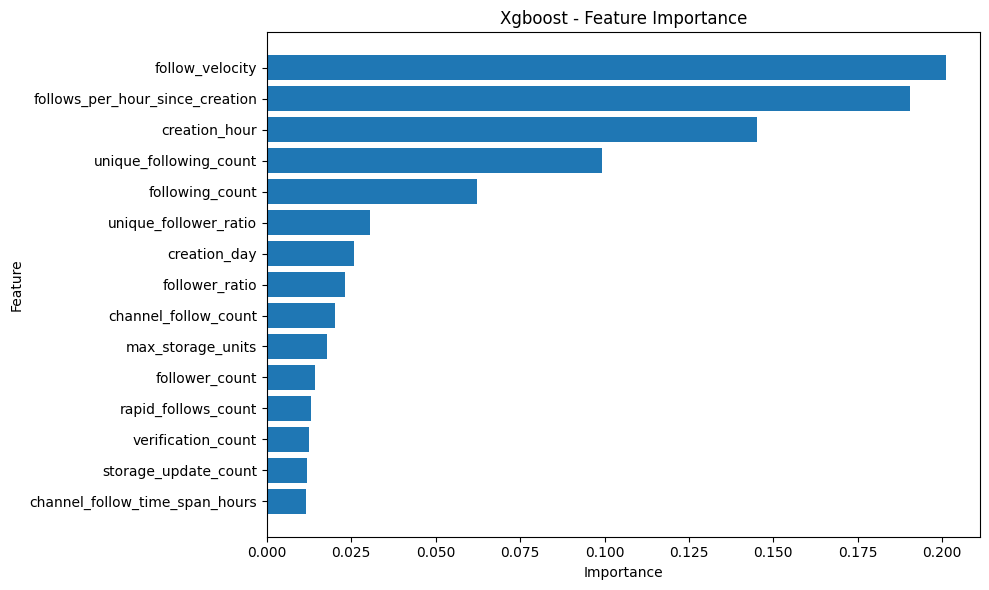

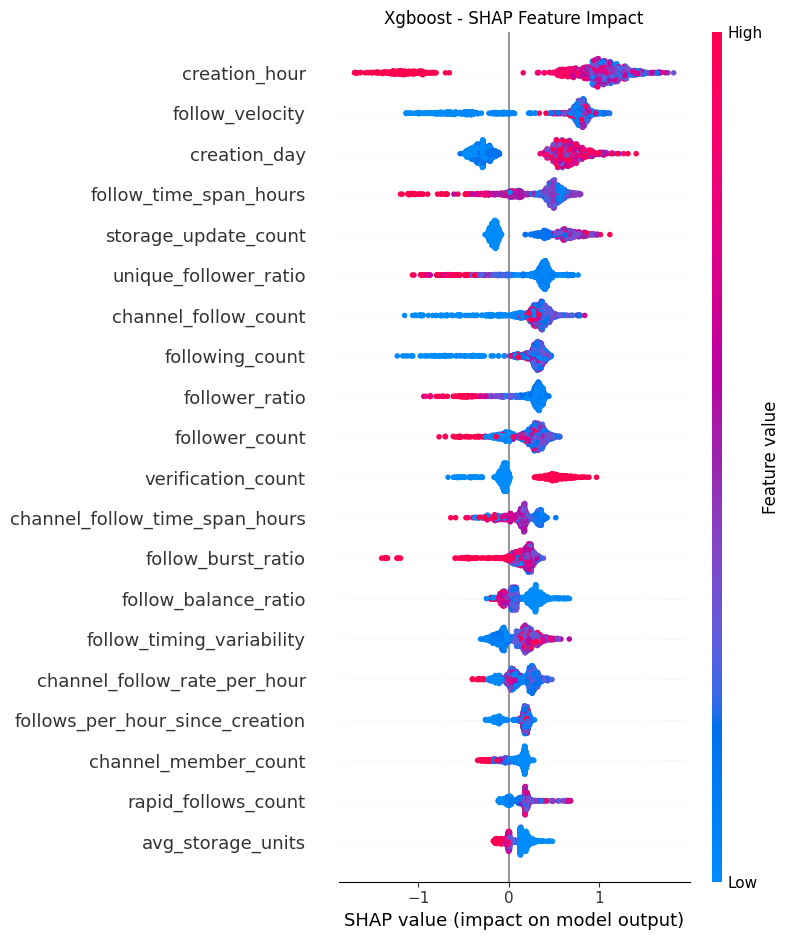

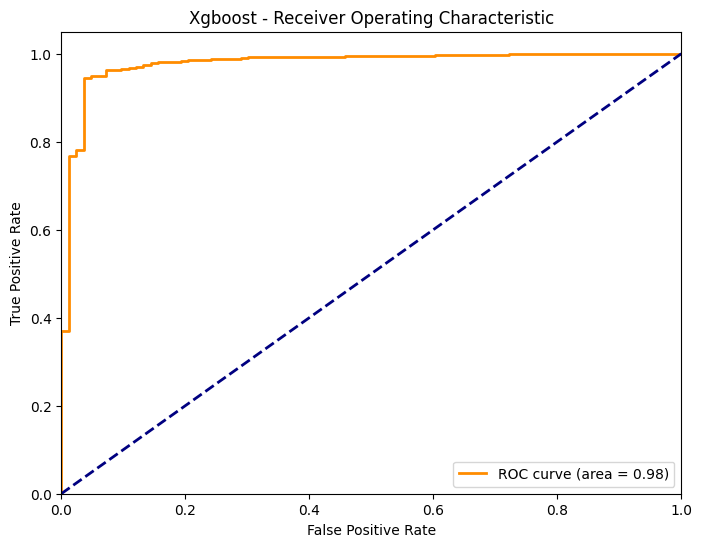

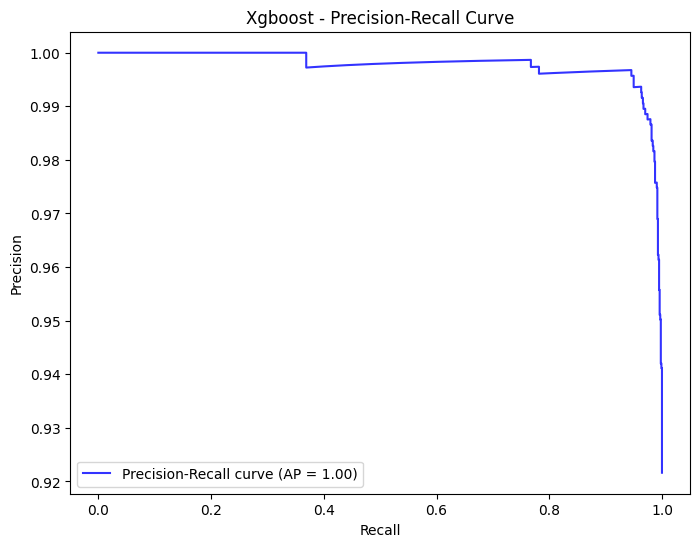

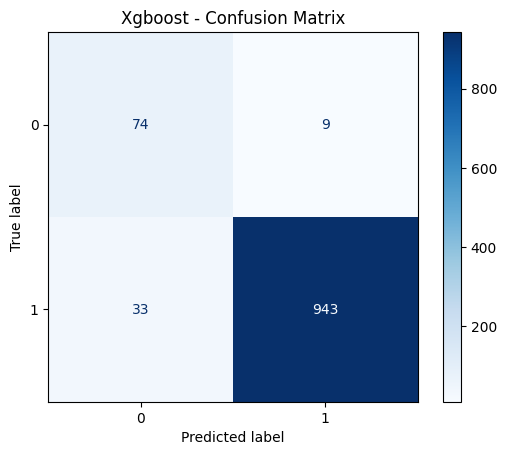

{'xgboost': {'average_precision': np.float64(0.9977376608902624),
             'classification_report': '              precision    recall  '
                                      'f1-score   support\n'
                                      '\n'
                                      '   Non-Sybil       0.83      0.78      '
                                      '0.81        83\n'
                                      '       Sybil       0.98      0.99      '
                                      '0.98       976\n'
                                      '\n'
                                      '    accuracy                           '
                                      '0.97      1059\n'
                                      '   macro avg       0.91      0.88      '
                                      '0.90      1059\n'
                                      'weighted avg       0.97      0.97      '
                                      '0.97      1059\n',
             'confusion_m

In [24]:
data = enhanced_features.join(labels_df, on='fid', how='inner')
print(f"Number of samples after merge: {data.shape[0]}")
X, feature_names = prepare_features(data)
y = data['bot'].to_numpy()

# Train models
results, importance, shap_vals, trained_pipelines, X_test, y_test, best_params_dict = train_quick_models(X, y, feature_names)

# Optionally, plot diagnostics
plot_model_diagnostics(results, importance, shap_vals, trained_pipelines, X_test, y_test, feature_names)
from pprint import pprint

pprint(results)

In [ ]:
trained_pipelines

{'xgboost': Pipeline(steps=[('xgb',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=0.8, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric='auc',
                                feature_types=None, gamma=0, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.05,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=5, max_leaves=None, min_child_weight=1,
                                missing=nan, monotone_constraints=None,
                                multi_strategy=None, n_estimators=200,
               

In [ ]:
# Add these imports at the top
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer
import optuna

def add_interaction_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add interaction-based features that capture complex bot behaviors"""
    return df.with_columns([
        # Authenticity score combining multiple signals
        ((pl.col('has_bio').cast(pl.Float32) * 0.3 +
          pl.col('has_avatar').cast(pl.Float32) * 0.3 +
          pl.col('verification_count').cast(pl.Float32) * 0.4) /
         (1 + pl.col('rapid_follows_count') / 100)
        ).alias('authenticity_score'),
        
        # Activity rhythm score
        (pl.col('hour_distribution_std') * 
         pl.col('active_hours_count') / 24.0
        ).alias('activity_rhythm_score'),
        
        # Behavioral consistency
        (pl.col('follow_timing_variability') * 
         pl.col('profile_completion_score')
        ).alias('behavioral_consistency'),
        
        # Network growth anomaly
        ((pl.col('following_count') - pl.col('follower_count')).abs() /
         (pl.col('follow_time_span_hours') + 1)
        ).alias('network_growth_anomaly')
    ])

def create_ensemble_model(X_train, y_train, cv):
    """Create an ensemble of multiple models"""
    
    # Base models
    models = {
        'xgb': xgb.XGBClassifier(
            eval_metric='auc',
            use_label_encoder=False
        ),
        'rf': RandomForestClassifier(
            n_jobs=-1,
            random_state=42
        ),
        'lgbm': LGBMClassifier(
            n_jobs=-1,
            random_state=42
        )
    }
    
    # Optimize each base model
    optimized_models = {}
    
    for name, model in models.items():
        def objective(trial):
            if name == 'xgb':
                params = {
                    'max_depth': trial.suggest_int('max_depth', 3, 7),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                }
            elif name == 'rf':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 7),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                }
            else:  # lgbm
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 7),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                }
            
            model.set_params(**params)
            scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
            return scores.mean()
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        # Create optimized model
        optimized_models[name] = type(model)(**study.best_params)
        
    # Create voting classifier
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        voting='soft'
    )
    
    return ensemble

def evaluate_model_stability(model, X, y, n_splits=5):
    """Evaluate model stability across different data splits"""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {
        'roc_auc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        metrics['roc_auc'].append(roc_auc_score(y_val, y_pred_proba))
        metrics['precision'].append(precision_score(y_val, y_pred))
        metrics['recall'].append(recall_score(y_val, y_pred))
        metrics['f1'].append(f1_score(y_val, y_pred))
    
    return {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in metrics.items()}

In [ ]:
# Create enhanced features
enhanced_features = add_interaction_features(enhanced_features)

data = enhanced_features.join(labels_df, on='fid', how='inner')

# Train and evaluate ensemble
X, feature_names = prepare_features(data)
y = data['bot'].to_numpy()

# Create and evaluate ensemble
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ensemble = create_ensemble_model(X, y, cv)

# Get stability metrics
stability_metrics = evaluate_model_stability(ensemble, X, y)

2024-12-04 23:39:31,490 INFO:Preparing feature matrix...
[I 2024-12-04 23:39:31,492] A new study created in memory with name: no-name-17861680-ade0-4585-af11-0d4290a93887


/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/joseribeiro/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-RMjVf8-3-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/joseri

[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.463597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-04 23:42:25,379] Trial 0 finished with value: 0.9877470320843814 and parameters: {'n_estimators': 433, 'max_depth': 4, 'learning_rate': 0.04575038597384673, 'num_leaves': 77}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:26,830] Trial 1 finished with value: 0.9870482663253748 and parameters: {'n_estimators': 348, 'max_depth': 3, 'learning_rate': 0.09252014745414089, 'num_leaves': 87}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:29,382] Trial 2 finished with value: 0.9876609441428718 and parameters: {'n_estimators': 366, 'max_depth': 4, 'learning_rate': 0.02697753204693677, 'num_leaves': 50}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:35,973] Trial 3 finished with value: 0.986819188843285 and parameters: {'n_estimators': 476, 'max_depth': 6, 'learning_rate': 0.035502512253627355, 'num_leaves': 100}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:37,618] Trial 4 finished with value: 0.9876998984950793 and parameters: {'n_estimators': 380, 'max_depth': 3, 'learning_rate': 0.024916175482230046, 'num_leaves': 71}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:42,766] Trial 5 finished with value: 0.9863545905232654 and parameters: {'n_estimators': 366, 'max_depth': 6, 'learning_rate': 0.06404004212234617, 'num_leaves': 30}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.463597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-12-04 23:42:44,191] Trial 6 finished with value: 0.9875373140915309 and parameters: {'n_estimators': 341, 'max_depth': 3, 'learning_rate': 0.09022395544274907, 'num_leaves': 67}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:48,041] Trial 7 finished with value: 0.9877005751945511 and parameters: {'n_estimators': 351, 'max_depth': 5, 'learning_rate': 0.02154235777987956, 'num_leaves': 77}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:42:51,221] Trial 8 finished with value: 0.9866975300469276 and parameters: {'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.09504570095652426, 'num_leaves': 70}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.463597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-04 23:42:59,544] Trial 9 finished with value: 0.9877362637362637 and parameters: {'n_estimators': 415, 'max_depth': 7, 'learning_rate': 0.024238489660841536, 'num_leaves': 59}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:01,798] Trial 10 finished with value: 0.9873091192609265 and parameters: {'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.05690036512976361, 'num_leaves': 40}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from sc

[I 2024-12-04 23:43:03,829] Trial 11 finished with value: 0.9866515144828398 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.04318326146848025, 'num_leaves': 56}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.463597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-04 23:43:12,408] Trial 12 finished with value: 0.9870287303058387 and parameters: {'n_estimators': 435, 'max_depth': 7, 'learning_rate': 0.01089262683713849, 'num_leaves': 89}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2024-12-04 23:43:14,024] Trial 13 finished with value: 0.9868790326139724 and parameters: {'n_estimators': 233, 'max_depth': 4, 'learning_rate': 0.07312394771652396, 'num_leaves': 56}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:20,297] Trial 14 finished with value: 0.9868017417655972 and parameters: {'n_estimators': 428, 'max_depth': 6, 'learning_rate': 0.04579856081104607, 'num_leaves': 44}. Best is trial 0 with value: 0.9877470320843814.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2024-12-04 23:43:23,213] Trial 15 finished with value: 0.9879866719625756 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.04075590192533149, 'num_leaves': 79}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:25,768] Trial 16 finished with value: 0.9873877929299615 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.0726011986812983, 'num_leaves': 84}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:26,868] Trial 17 finished with value: 0.9877350574459008 and parameters: {'n_estimators': 158, 'max_depth': 4, 'learning_rate': 0.04432304681078646, 'num_leaves': 96}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:29,983] Trial 18 finished with value: 0.987736822748871 and parameters: {'n_estimators': 314, 'max_depth': 5, 'learning_rate': 0.05502913398810454, 'num_leaves': 79}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 423

[I 2024-12-04 23:43:32,004] Trial 19 finished with value: 0.9877067831766627 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.03672866792057575, 'num_leaves': 20}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:34,673] Trial 20 finished with value: 0.9868026538387985 and parameters: {'n_estimators': 189, 'max_depth': 6, 'learning_rate': 0.06639928925557352, 'num_leaves': 76}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:37,800] Trial 21 finished with value: 0.9874521088015064 and parameters: {'n_estimators': 315, 'max_depth': 5, 'learning_rate': 0.05355684443265267, 'num_leaves': 80}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:40,839] Trial 22 finished with value: 0.9876276093384527 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.05549218322416676, 'num_leaves': 65}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:43,560] Trial 23 finished with value: 0.9878789884813981 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.03540980595998346, 'num_leaves': 92}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:45,298] Trial 24 finished with value: 0.9877869279315062 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.034649515082169596, 'num_leaves': 93}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:47,999] Trial 25 finished with value: 0.9872848463450874 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.03401997215836314, 'num_leaves': 93}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:51,404] Trial 26 finished with value: 0.9842565867867072 and parameters: {'n_estimators': 208, 'max_depth': 6, 'learning_rate': 0.012126466157534509, 'num_leaves': 92}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.463597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-12-04 23:43:53,232] Trial 27 finished with value: 0.9878954940641688 and parameters: {'n_estimators': 261, 'max_depth': 4, 'learning_rate': 0.03160306934243964, 'num_leaves': 100}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:55,302] Trial 28 finished with value: 0.9859452461862102 and parameters: {'n_estimators': 166, 'max_depth': 5, 'learning_rate': 0.017637691072608146, 'num_leaves': 100}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:56,547] Trial 29 finished with value: 0.9876923665357399 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.04066975893530959, 'num_leaves': 84}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:58,160] Trial 30 finished with value: 0.9874687614928579 and parameters: {'n_estimators': 213, 'max_depth': 4, 'learning_rate': 0.028890174585321424, 'num_leaves': 85}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:43:59,825] Trial 31 finished with value: 0.9875578210277005 and parameters: {'n_estimators': 238, 'max_depth': 4, 'learning_rate': 0.0315896846415103, 'num_leaves': 95}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:00,938] Trial 32 finished with value: 0.9873796136928666 and parameters: {'n_estimators': 266, 'max_depth': 3, 'learning_rate': 0.04782377472432808, 'num_leaves': 90}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.46359

[I 2024-12-04 23:44:02,590] Trial 33 finished with value: 0.9872899068802683 and parameters: {'n_estimators': 249, 'max_depth': 4, 'learning_rate': 0.039194004547456154, 'num_leaves': 97}. Best is trial 15 with value: 0.9879866719625756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:04,832] Trial 34 finished with value: 0.9880388955087749 and parameters: {'n_estimators': 324, 'max_depth': 4, 'learning_rate': 0.03153105202317774, 'num_leaves': 89}. Best is trial 34 with value: 0.9880388955087749.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:07,227] Trial 35 finished with value: 0.9880583726848787 and parameters: {'n_estimators': 333, 'max_depth': 4, 'learning_rate': 0.01958062577211904, 'num_leaves': 88}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:08,728] Trial 36 finished with value: 0.9870450005148801 and parameters: {'n_estimators': 327, 'max_depth': 3, 'learning_rate': 0.016786725492412394, 'num_leaves': 74}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:10,353] Trial 37 finished with value: 0.9877009282551452 and parameters: {'n_estimators': 389, 'max_depth': 3, 'learning_rate': 0.02756237676696489, 'num_leaves': 82}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:12,859] Trial 38 finished with value: 0.9878914927107699 and parameters: {'n_estimators': 340, 'max_depth': 4, 'learning_rate': 0.020217814666083446, 'num_leaves': 87}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:15,466] Trial 39 finished with value: 0.9873085602483194 and parameters: {'n_estimators': 389, 'max_depth': 4, 'learning_rate': 0.030107858627191217, 'num_leaves': 87}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3900, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5821
[LightGBM] [Info] Number of data points in the train set: 4232, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.921550 -> initscore=2.463597
[LightGBM] [Info] Start training from score 2.463597
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-12-04 23:44:16,842] Trial 40 finished with value: 0.9871005487150064 and parameters: {'n_estimators': 312, 'max_depth': 3, 'learning_rate': 0.04953131928228985, 'num_leaves': 100}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:19,232] Trial 41 finished with value: 0.9875323712432147 and parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.021347370295502176, 'num_leaves': 88}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:21,806] Trial 42 finished with value: 0.9875880665519219 and parameters: {'n_estimators': 356, 'max_depth': 4, 'learning_rate': 0.017340342810266238, 'num_leaves': 73}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:24,158] Trial 43 finished with value: 0.9878162908042425 and parameters: {'n_estimators': 330, 'max_depth': 4, 'learning_rate': 0.022721462688161213, 'num_leaves': 67}. Best is trial 35 with value: 0.9880583726848787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:26,589] Trial 44 finished with value: 0.9881628197772777 and parameters: {'n_estimators': 361, 'max_depth': 4, 'learning_rate': 0.024645759079276897, 'num_leaves': 81}. Best is trial 44 with value: 0.9881628197772777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:29,339] Trial 45 finished with value: 0.9878606293305088 and parameters: {'n_estimators': 373, 'max_depth': 4, 'learning_rate': 0.013943906304579548, 'num_leaves': 80}. Best is trial 44 with value: 0.9881628197772777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:31,028] Trial 46 finished with value: 0.9877782779469525 and parameters: {'n_estimators': 412, 'max_depth': 3, 'learning_rate': 0.026480420387703325, 'num_leaves': 97}. Best is trial 44 with value: 0.9881628197772777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:35,394] Trial 47 finished with value: 0.98653785839328 and parameters: {'n_estimators': 289, 'max_depth': 6, 'learning_rate': 0.03982623106987783, 'num_leaves': 64}. Best is trial 44 with value: 0.9881628197772777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:38,652] Trial 48 finished with value: 0.9873628433146507 and parameters: {'n_estimators': 303, 'max_depth': 5, 'learning_rate': 0.02454320394765458, 'num_leaves': 71}. Best is trial 44 with value: 0.9881628197772777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-04 23:44:43,115] Trial 49 finished with value: 0.9875568206893508 and parameters: {'n_estimators': 446, 'max_depth': 5, 'learning_rate': 0.030963744618966563, 'num_leaves': 83}. Best is trial 44 with value: 0.9881628197772777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
stability_metrics

{'roc_auc': {'mean': np.float64(0.9889201935948924),
  'std': np.float64(0.004393393601547087)},
 'precision': {'mean': np.float64(0.9837069385017122),
  'std': np.float64(0.0035382210224283663)},
 'recall': {'mean': np.float64(0.9901538461538462),
  'std': np.float64(0.0021119241314845128)},
 'f1': {'mean': np.float64(0.9869168335620625),
  'std': np.float64(0.0023529350232976407)}}

In [ ]:
import joblib
from typing import Dict, List, Tuple
import numpy as np
from datetime import datetime

class BotDetectionSystem:
    def __init__(self, model, feature_names: List[str], confidence_thresholds: Dict[str, float] = None):
        self.model = model
        self.feature_names = feature_names
        self.confidence_thresholds = confidence_thresholds or {
            'high': 0.95,
            'medium': 0.85,
            'low': 0.70
        }
        
    def predict_with_confidence(self, features: np.ndarray) -> List[Dict]:
        """
        Make predictions with confidence levels
        """
        probabilities = self.model.predict_proba(features)[:, 1]
        
        predictions = []
        for prob in probabilities:
            if prob >= self.confidence_thresholds['high']:
                confidence = 'high'
            elif prob >= self.confidence_thresholds['medium']:
                confidence = 'medium'
            elif prob >= self.confidence_thresholds['low']:
                confidence = 'low'
            else:
                confidence = 'very_low'
                
            predictions.append({
                'is_bot': prob >= 0.5,
                'probability': float(prob),
                'confidence': confidence
            })
            
        return predictions
    
    def analyze_predictions(self, features: np.ndarray, fids: np.ndarray) -> Dict:
        """
        Analyze predictions and provide detailed insights
        """
        predictions = self.predict_with_confidence(features)
        
        # Aggregate statistics
        stats = {
            'total_analyzed': len(predictions),
            'total_bots': sum(1 for p in predictions if p['is_bot']),
            'confidence_levels': {
                'high': sum(1 for p in predictions if p['confidence'] == 'high'),
                'medium': sum(1 for p in predictions if p['confidence'] == 'medium'),
                'low': sum(1 for p in predictions if p['confidence'] == 'low'),
                'very_low': sum(1 for p in predictions if p['confidence'] == 'very_low')
            }
        }
        
        # High-confidence bots
        high_confidence_bots = [
            {'fid': int(fid), 'probability': float(pred['probability'])}
            for fid, pred in zip(fids, predictions)
            if pred['is_bot'] and pred['confidence'] == 'high'
        ]

        non_bots = [
            {'fid': int(fid), 'probability': float(pred['probability'])}
            for fid, pred in zip(fids, predictions)
            if not pred['is_bot'] and pred['confidence'] == 'high'
        ]
        
        return {
            'statistics': stats,
            'high_confidence_bots': high_confidence_bots,
            'non_bots': non_bots,
            'timestamp': datetime.now().isoformat()
        }
    
    def save(self, filepath: str):
        """Save the model and configuration"""
        save_dict = {
            'model': self.model,
            'feature_names': self.feature_names,
            'confidence_thresholds': self.confidence_thresholds
        }
        joblib.dump(save_dict, filepath)
    
    @classmethod
    def load(cls, filepath: str) -> 'BotDetectionSystem':
        """Load a saved model"""
        save_dict = joblib.load(filepath)
        return cls(
            model=save_dict['model'],
            feature_names=save_dict['feature_names'],
            confidence_thresholds=save_dict['confidence_thresholds']
        )

def create_monitoring_report(predictions: List[Dict], previous_predictions: List[Dict] = None) -> Dict:
    """
    Create a monitoring report to track system performance
    """
    current_stats = {
        'total_predictions': len(predictions),
        'bot_rate': sum(1 for p in predictions if p['is_bot']) / len(predictions),
        'confidence_distribution': {
            level: sum(1 for p in predictions if p['confidence'] == level) / len(predictions)
            for level in ['high', 'medium', 'low', 'very_low']
        }
    }
    
    if previous_predictions:
        # Calculate changes from previous period
        previous_bot_rate = sum(1 for p in previous_predictions if p['is_bot']) / len(previous_predictions)
        current_stats['bot_rate_change'] = current_stats['bot_rate'] - previous_bot_rate
    
    return current_stats

In [ ]:
# Create detection system
detection_system = BotDetectionSystem(
    model=ensemble,  # Your trained ensemble model
    feature_names=feature_names
)

# Save model
detection_system.save('bot_detection_model.joblib')

In [ ]:
# Make predictions
X_new = X  # Your feature matrix
fids = data['fid'].to_numpy()  # Your FIDs

analysis_results = detection_system.analyze_predictions(X_new, fids)
print("\nAnalysis Results:")
pprint(analysis_results)


Analysis Results:
{'high_confidence_bots': [{'fid': 8505, 'probability': 0.9959555746838361},
                          {'fid': 9583, 'probability': 0.9947847588960129},
                          {'fid': 13074, 'probability': 0.9730957022811317},
                          {'fid': 14272, 'probability': 0.9917937235552309},
                          {'fid': 14300, 'probability': 0.9953198641309959},
                          {'fid': 14370, 'probability': 0.9871313928445663},
                          {'fid': 14405, 'probability': 0.9894366144553192},
                          {'fid': 14437, 'probability': 0.9900563709690718},
                          {'fid': 14450, 'probability': 0.9962748251375452},
                          {'fid': 14543, 'probability': 0.9935255839679785},
                          {'fid': 14598, 'probability': 0.9914067338714886},
                          {'fid': 14955, 'probability': 0.9781920633910764},
                          {'fid': 14967, 'probability': 0.9

In [ ]:
def add_authenticity_features(df: pl.DataFrame) -> pl.DataFrame:
    """Add features specifically designed to identify genuine users"""
    return df.with_columns([
        # Profile authenticity score (weighted combination of trust signals)
        ((pl.col('has_bio').cast(pl.Float32) * 0.2 +
          pl.col('has_avatar').cast(pl.Float32) * 0.2 +
          pl.col('verification_count').cast(pl.Float32) * 0.3 +
          pl.col('has_ens').cast(pl.Float32) * 0.3) *
         (1 - pl.col('rapid_follow_ratio') * 0.5)  # Penalize rapid following
        ).alias('authenticity_score'),
        
        # Engagement quality score
        ((pl.col('follower_ratio') * 0.3 +
          (pl.col('channel_member_count') > 0).cast(pl.Float32) * 0.2 +
          (pl.col('verification_count') > 0).cast(pl.Float32) * 0.5)
        ).alias('engagement_quality'),
        
        # Natural behavior score
        (1 - (pl.col('follow_burst_ratio') + 
              pl.col('odd_hours_follow_ratio')) / 2
        ).alias('natural_behavior_score'),
        
        # Account stability
        ((pl.col('follow_time_span_hours') > 24 * 7).cast(pl.Float32) *  # Active > 1 week
         (pl.col('profile_completion_score') / 3)
        ).alias('account_stability')
    ])


NameError: name 'pl' is not defined

In [ ]:
class EnhancedBotDetectionSystem(BotDetectionSystem):
    def __init__(self, model, feature_names: List[str], 
                 confidence_thresholds: Dict[str, float] = None,
                 authenticity_thresholds: Dict[str, float] = None):
        super().__init__(model, feature_names, confidence_thresholds)
        self.authenticity_thresholds = authenticity_thresholds or {
            'high': 0.8,
            'medium': 0.6,
            'low': 0.4
        }
    
    def predict_with_authenticity(self, features: np.ndarray, 
                                authenticity_features: np.ndarray) -> List[Dict]:
        """Make predictions with both bot detection and authenticity assessment"""
        bot_probabilities = self.model.predict_proba(features)[:, 1]
        
        predictions = []
        for prob, auth_scores in zip(bot_probabilities, authenticity_features):
            # Combine multiple authenticity signals
            authenticity_score = np.mean([
                auth_scores[0],  # authenticity_score
                auth_scores[1],  # engagement_quality
                auth_scores[2],  # natural_behavior_score
                auth_scores[3]   # account_stability
            ])
            
            # Determine confidence levels
            if prob <= 0.1 and authenticity_score >= self.authenticity_thresholds['high']:
                confidence = 'high_authentic'
            elif prob <= 0.2 and authenticity_score >= self.authenticity_thresholds['medium']:
                confidence = 'medium_authentic'
            elif prob >= self.confidence_thresholds['high']:
                confidence = 'high_bot'
            elif prob >= self.confidence_thresholds['medium']:
                confidence = 'medium_bot'
            else:
                confidence = 'uncertain'
            
            predictions.append({
                'is_bot': prob >= 0.5,
                'is_authentic': authenticity_score >= self.authenticity_thresholds['medium'],
                'bot_probability': float(prob),
                'authenticity_score': float(authenticity_score),
                'confidence': confidence
            })
        
        return predictions

    def analyze_account_status(self, features: np.ndarray, 
                             authenticity_features: np.ndarray,
                             fids: np.ndarray) -> Dict:
        """Detailed analysis of account status"""
        predictions = self.predict_with_authenticity(features, authenticity_features)
        
        stats = {
            'total_analyzed': len(predictions),
            'authentic_accounts': sum(1 for p in predictions if p['is_authentic']),
            'suspected_bots': sum(1 for p in predictions if p['is_bot']),
            'uncertain': sum(1 for p in predictions 
                           if not p['is_bot'] and not p['is_authentic']),
            'confidence_levels': {
                'high_authentic': sum(1 for p in predictions 
                                   if p['confidence'] == 'high_authentic'),
                'medium_authentic': sum(1 for p in predictions 
                                     if p['confidence'] == 'medium_authentic'),
                'high_bot': sum(1 for p in predictions 
                              if p['confidence'] == 'high_bot'),
                'medium_bot': sum(1 for p in predictions 
                                if p['confidence'] == 'medium_bot'),
                'uncertain': sum(1 for p in predictions 
                               if p['confidence'] == 'uncertain')
            }
        }
        
        # High-confidence authentic accounts
        authentic_accounts = [
            {
                'fid': int(fid),
                'authenticity_score': float(pred['authenticity_score']),
                'bot_probability': float(pred['bot_probability'])
            }
            for fid, pred in zip(fids, predictions)
            if pred['confidence'] == 'high_authentic'
        ]
        
        return {
            'statistics': stats,
            'authentic_accounts': authentic_accounts,
            'timestamp': datetime.now().isoformat()
        }

NameError: name 'BotDetectionSystem' is not defined

In [ ]:
# Add authenticity features
enhanced_features = add_authenticity_features(enhanced_features)
data = enhanced_features.join(labels_df, on='fid', how='inner')

# Train and evaluate ensemble
X, feature_names = prepare_features(data)
authenticity_features = enhanced_features.select([
    'authenticity_score', 'engagement_quality',
    'natural_behavior_score', 'account_stability'
]).to_numpy()

# Create enhanced detection system
detection_system = EnhancedBotDetectionSystem(
    model=ensemble,
    feature_names=feature_names
)

# Analyze accounts
analysis = detection_system.analyze_account_status(
    X, authenticity_features, enhanced_features['fid'].to_numpy()
)
print("\nAccount Analysis:")
pprint(analysis)

NameError: name 'add_authenticity_features' is not defined